# AE EXERCISE - Credi Card fraud

AEs have a variety of possible applications, including anomaly detection. After training on a
dataset that is expected to have few abnormal values, when the system encounters data that is
abnormal, very different from the rest, it may be able to detect it thanks to the rebuild error.
Because that data is very different from the other, the rebuild error will be high. This allows us to
detect anomalies in an unsupervised way, since no prior information about anomalies is
necessary, the model detects them directly thanks to this error.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score


Let's look at it as an application example about the following Kaggle https://www.kaggle.com/mlgulb/creditcardfraud This set is similar to the one we saw in the SOM example, only with a larger
number of records. User information is presented from a financial institution encoded with a
number of variables of which its meaning is unknown, except for one in particular, Amount, which
indicates the number of transactions. Along with this is a label indicating transactions that have
been identified as fraudulent versus those that are not (Class variable)

After that, we define the funtion to build the AE model. This function can be specified using the
Keras library from its Sequential specification. In this way, the AE is defined with a first step to
receive the input data and pass it to TensorFlow tensors. The encoding layer is then defined.
This layer is a fully connected layer. In it we also include an L1 regularization to be able to avoid
overfit in the event that the hidden units are equal to or greater than the input units. Finally, a
decoding layer is defined, which has as its activation function the sigmoid function to return values
in a range 0 to 1. Finally, everything integrates with the Model class, which receives as input the
encoder layer, as output the decoder, and then compiles everything. We define as a cost function
the MSE, which will be calculated by comparing the output of the AE with the same data entry of
the AE (rather than with a Y variable, as we have seen in the supervised learning part). In this
way, we will be optimizing the reconstruction error.
As we see, the object of the previous layer is sent to the class after each layer is instantiated. In
this way, we could, if wanted, introduce more intermediate layers into the AE.

In [2]:
def autoencoder_function(nv, nh, optimizer="adam",
                         loss='mean_squared_error',
                         metrics=['accuracy']):
    """
    Main function to define the AE Neural Network.

    Parameters
    ----------
    nv : TYPE
        DESCRIPTION.
    nh : TYPE
        DESCRIPTION.
    optimizer : TYPE, optional
        DESCRIPTION. The default is "adam".
    loss : TYPE, optional
        DESCRIPTION. The default is 'mean_squared_error'.
    metrics : TYPE, optional
        DESCRIPTION. The default is ['accuracy'].

    Returns
    -------
    autoencoder : TYPE
        DESCRIPTION.

    """

    # Define input
    input_layer = Input(shape=(nv,))

    # Encoding
    encoder = Dense(nh, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
    # Decoding
    decoder = Dense(nv, activation='sigmoid')(encoder)

    # Model
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return autoencoder

Defined the AE, we proceed to load the data for the problem. In addition, we disable TensorFlow's
eager execution, because the NN structure we're building can cause compatibility issues with it.

In [3]:
# ===========================================================================
# 1. Prepare data
# ===========================================================================
# Disable eager_exec
tf.compat.v1.disable_eager_execution()
# Load & prepare data
df_raw = pd.read_csv("creditcard.csv").drop(columns=['Time'])


Loaded the data, let's analyze the proportion of each of the classes (Fraudulent vs Normal).

Text(0.5, 1.0, 'Normal vs Fraud Clients')

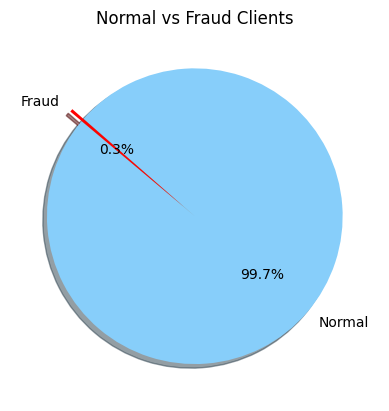

In [4]:

# Plot target variable
labels = ['Normal', 'Fraud']
sizes = [len(df_raw[df_raw['Class']==0]), len(df_raw[df_raw['Class']==1])]
colors = ['lightskyblue','red']
explode = (0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Normal vs Fraud Clients")


As we can see, there is a huge imbalance between the two classes, which makes it difficult to
predict fraud with a classic supervised learning model, even if this label is available. This is
common in many domains. In this case, of all bank transactions, perhaps only a few have been
detected as fraud, but that does not mean that the rest of those that have not been fraudulent are
actually normal transactions. Thanks to models such as the AE, we can work with this scarce
fraud information and be able to detect it for other cases, even be able to detect it on the source
dataset and analyze which cases of normals are suspected of not being for being normal, similar
to what we saw with the SOM.
Continuing with the exercise, we normalize the variable Amount, which is the only one that is not
in a range of 0 to 1.

In [5]:
# Normalize
sc = MinMaxScaler(feature_range = (0, 1))
df_raw['Amount'] = sc.fit_transform(df_raw['Amount'].values.reshape(-1, 1))


Supervised case
Now, let's look at the supervised approach. If we have these fraud tags, we will train the AE only
on non-fraud data, to encourage the reconstruction error to increase for cases of potential fraud
that are received. We separate the data into a training part (with which we will adjust the model)
and a test part, which will not see the model in your training and that we will use for subsequent
analysis.

In [6]:
# =============================================================================
# 2. Supervised
# =============================================================================
# Train/Eval split
X_train, X_test = train_test_split(df_raw, test_size=0.2, random_state=42)

# Train only in non outliers
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

After that, we define the model's hypeparameters, and train the AE on the train data. The output
on which the model is evaluated is the same training matrix. This will, as we discussed earlier,
make the error we are trying to minimize the reconstruction error.

In [10]:
# Parameters
nv = X_train.shape[1] # visible unists
nh = 32 # hidden units
epochs = 50
batch_size = 256
# Train AE
model = autoencoder_function(nv, nh,optimizer="adam",
loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Train on 22184 samples
Epoch 1/50
22184/22184 [==============================] - 0s 21us/sample - loss: 1.1709 - accuracy: 0.1365
Epoch 2/50
22184/22184 [==============================] - 0s 11us/sample - loss: 0.9685 - accuracy: 0.3379
Epoch 3/50
22184/22184 [==============================] - 0s 10us/sample - loss: 0.8868 - accuracy: 0.4549
Epoch 4/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.8462 - accuracy: 0.5387
Epoch 5/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.8208 - accuracy: 0.5956
Epoch 6/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.8027 - accuracy: 0.6334
Epoch 7/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.7885 - accuracy: 0.6607
Epoch 8/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.7767 - accuracy: 0.6852
Epoch 9/50
22184/22184 [==============================] - 0s 9us/sample - loss: 0.7674 - accuracy: 0.7076
Epoch 10/50
22184/22

We can see the validation results along the epochs as follows.

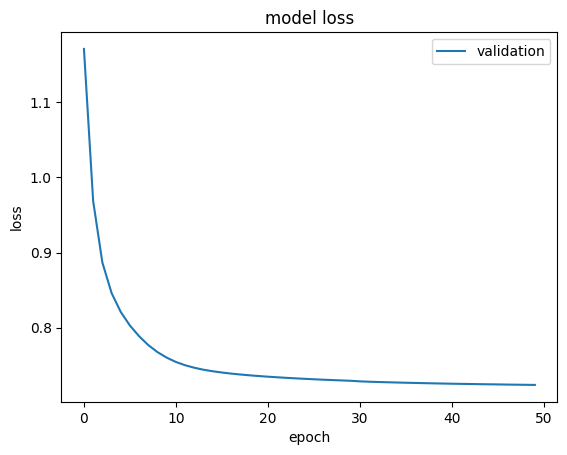

In [11]:
# Plot metrics
plt_history = history.history
plt.plot(plt_history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper right')

The next step is to predict anomalies with the AE based on the value of the reconstruction error.
This implies that we define a threshold for such a reconstruction error, from which anomalies are
considered. In this example we will define it manually, as we see below. However, in the
supervised approximation, the threshold value can be defined as an adjustable parameter of the
model, so that it maximizes the number of detected anomalies known in the training data, while
minimise false positives.

In [12]:
# Obtain predictions
threshold = 2.9 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis=1)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


We can visualize what this threshold looks like on a graph that shows the reconstruction error,
seeing the values with anomalies of the test data, versus the ones that do not, and checking what
the discrimination between classes is like.

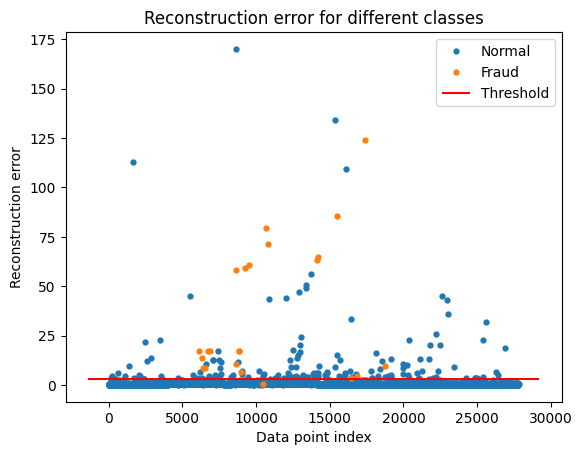

In [13]:
# Visualize [Chart]
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
 ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5,
linestyle='',
 label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r",
zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

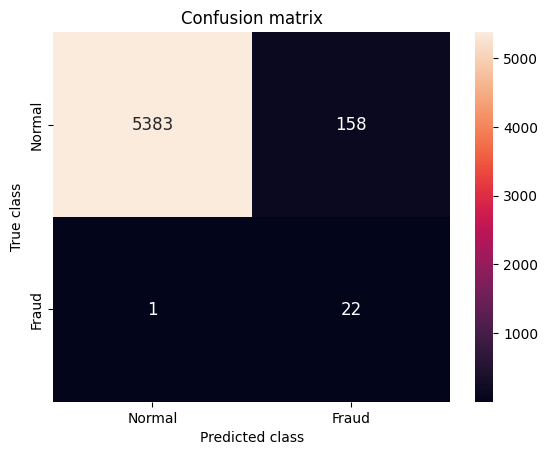

In [14]:
# Visualize [CM]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels,
            annot=True, fmt="d", annot_kws={"fontsize":12})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Unsupervised case
For this case, we ignore the information in the Class variable. Therefore, the AE is trained with
mixed data from anomalies/non-anomalies

In [15]:
# Other metrics
print("F1 score: ", f1_score(error_df.true_class, y_pred))

# =============================================================================
# 3. Unsupervised
# =============================================================================
# Train/Eval split
df_input = df_raw.copy().drop(columns=['Class']) # No class column
X_train, X_test = train_test_split(df_input, test_size=0.2, random_state=42)

# Parameters
nv = X_train.shape[1] # visible unists
nh = 32 # hidden units
epochs=50
batch_size=256

# Train AE
model = autoencoder_function(nv, nh,optimizer="adam", loss='mean_squared_error',
                             metrics=['accuracy'])
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True)

F1 score:  0.2167487684729064
Train on 22255 samples
Epoch 1/50
22255/22255 [==============================] - 0s 17us/sample - loss: nan - accuracy: 0.0758
Epoch 2/50
22255/22255 [==============================] - 0s 10us/sample - loss: nan - accuracy: 0.0688
Epoch 3/50
22255/22255 [==============================] - 0s 10us/sample - loss: nan - accuracy: 0.0688
Epoch 4/50
22255/22255 [==============================] - 0s 10us/sample - loss: nan - accuracy: 0.0688
Epoch 5/50
22255/22255 [==============================] - 0s 10us/sample - loss: nan - accuracy: 0.0688
Epoch 6/50
22255/22255 [==============================] - 0s 10us/sample - loss: nan - accuracy: 0.0688
Epoch 7/50
22255/22255 [==============================] - 0s 7us/sample - loss: nan - accuracy: 0.0688
Epoch 8/50
22255/22255 [==============================] - 0s 7us/sample - loss: nan - accuracy: 0.0688
Epoch 9/50
22255/22255 [==============================] - 0s 7us/sample - loss: nan - accuracy: 0.0688
Epoch 10/50
22

Again, we need to set the threshold the reconstruction error. Without a priori information, it can
be done in several ways. For example, we could see a boxplot of the distribution of errors, and
consider as threshold the upper whisker of the boxplot. For this example, let's define it based on
a mere visual criterion. If, for example, we set it to 25, the following remains

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


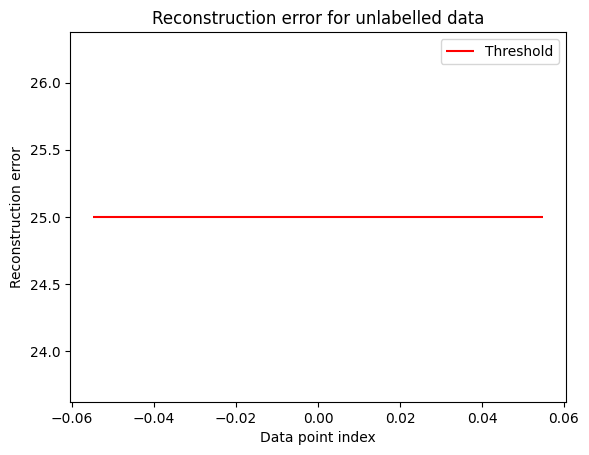

In [16]:
# Obtain predictions
threshold = 2.9 # Set threshold for reconstruction error
threshold = 25 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis=1)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Visualize [Chart]
fig, ax = plt.subplots()

ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for unlabelled data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

